# Assignment 3
## Group members: (Amber) Ying Wu, Ruchika Venkateswaran, Yixuan Wang

In [29]:
import pandas as pd, numpy as np, os, warnings, seaborn as sns, matplotlib.pyplot as plt, matplotlib
from datetime import datetime

warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.options.mode.chained_assignment = None
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('seaborn')
sns.set_color_codes('colorblind')
matplotlib.rcParams.update({'font.size': 14}) 
matplotlib.rcParams.update({'xtick.labelsize':16})
matplotlib.rcParams.update({'ytick.labelsize':16})
matplotlib.rcParams.update({'axes.labelsize':16})
matplotlib.rcParams.update({'axes.titlesize':20})
matplotlib.rcParams.update({'legend.fontsize': 16}) 
sns.set_style('white')

In [30]:
df = pd.read_csv('Winters-Attribution-PS3.csv', index_col=0)

In [31]:
df.head(5)

,Orderid,Orderdatetime,Saleamount,Newcustomer,Position,Positiondatetime,Groupname,Networkname,Networkid,Brand,Positionname,DaysToConvert
1,11634052,2012-05-01 4:24,341.5,Y,1,2012-05-01 3:49,BUZZ AFFILIATE,Buzz CPA Affiliate,buzz23,N,CONVERTER,0
2,11634052,2012-05-01 4:24,341.5,Y,0,2012-05-01 3:47,SEARCH GOOGLE BRAND,G: Medifast Brand Terms > Medifast >,g000793,Y,ORIGINATOR,0
3,11634059,2012-05-01 4:08,339.0,Y,2,2012-04-29 21:01,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,CONVERTER,2
4,11634059,2012-05-01 4:08,339.0,Y,1,2012-04-24 5:29,CPM,Armonix,nar7467,N,ASSIST,7
5,11634059,2012-05-01 4:08,339.0,Y,0,2012-04-23 2:46,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,ORIGINATOR,8


In [32]:
df.shape

(7624, 12)

In [33]:
print('Time range: ', df['Orderdatetime'].min(), 'to', df['Orderdatetime'].max())
print('Number of touchpoints:', len(df))
print('Number of orders:', len(df['Orderid'].unique()))
print('Number of touchpoints per order:', np.round(len(df)/len(df['Orderid'].unique()), 2))

Time range:  2012-05-01 10:04 to 2012-06-01 3:45
Number of touchpoints: 7624
Number of orders: 1627
Number of touchpoints per order: 4.69


In [34]:
df.Positionname.unique()

array(['CONVERTER', 'ORIGINATOR', 'ASSIST', 'ROSTER'], dtype=object)

**Q1. (30 pts) Compare first-touch vs. last-touch attribution models**

**a) (10 pts) What is the number of orders attributed to each channel using a last-touch model? What about the number of orders attributed to each channel using a first-touch model? What is the corresponding share of credit from the two attribution models?** 

In [35]:
# calculating the count per channel by last touch
num_order = len(df['Orderid'].unique())
T_last_count = pd.DataFrame(df.loc[df['Positionname']=='CONVERTER', 
                            'Groupname'].value_counts()).reset_index().sort_values('index')
# calculating the percentage per channel by last touch
T_last_percent = pd.DataFrame((df.loc[df['Positionname']=='CONVERTER', 
                            'Groupname'].value_counts()/
                            num_order)*100).reset_index().sort_values('index')
# calculating the count per channel by first touch
T_first_count = pd.DataFrame(df.loc[df['Positionname']=='ORIGINATOR', 
                             'Groupname'].value_counts()).reset_index().sort_values('index')
# calculating the percentage per channel by first touch
T_first_percent = pd.DataFrame(df.loc[df['Positionname']=='ORIGINATOR', 
                             'Groupname'].value_counts()/
                             num_order*100).reset_index().sort_values('index')

In [36]:
# merging all 4 tables 
merge_1 = np.round(pd.merge(T_last_count, T_first_count, how = 'outer', on = 'index').fillna(0).rename(
    columns={"Groupname_x": "Converter", "Groupname_y": "Originator"}), 3)
merge_2= np.round(pd.merge(T_last_percent, T_first_percent, how = 'outer', on = 'index').fillna(0).rename(
    columns={"Groupname_x": "Converter %", "Groupname_y": "Originator %"}), 3)
first_last = np.round(pd.merge(merge_1, merge_2, how = 'outer', on = 'index').fillna(0), 3)

new_row = {'index': 'TOTAL', 'Converter': first_last.Converter.sum(), 'Originator': first_last.Originator.sum(), 'Converter %': first_last['Converter %'].sum(), 'Originator %': first_last['Originator %'].sum()}
first_last = first_last.append(new_row, ignore_index=True)
first_last = np.round(first_last, decimals=2)
first_last['Converter'] = first_last['Converter'].astype('int64')
first_last['Originator'] = first_last['Originator'].astype('int64')

The table below displays the number of orders and corresponding share of credit from the two attribution (first and last touch) models.

In [37]:
first_last

,index,Converter,Originator,Converter %,Originator %
0,BUZZ AFFILIATE,486,225,29.87,13.83
1,CJ,224,87,13.77,5.35
2,CPM,830,618,51.01,37.98
3,OTHER,3,20,0.18,1.23
4,PRINT - MAGAZINES,3,4,0.18,0.25
5,SEARCH GOOGLE NON-BRAND,32,53,1.97,3.26
6,SEARCH MSN NON-BRAND,7,4,0.43,0.25
7,TV,20,14,1.23,0.86
8,Uncategorized,22,9,1.35,0.55
9,DIRECT MAIL,0,1,0.00,0.06


**b) (10 pts) In a single bar chart, plot the share of credit (in percentage) for the first- and last touch attribution models by marketing channel.**

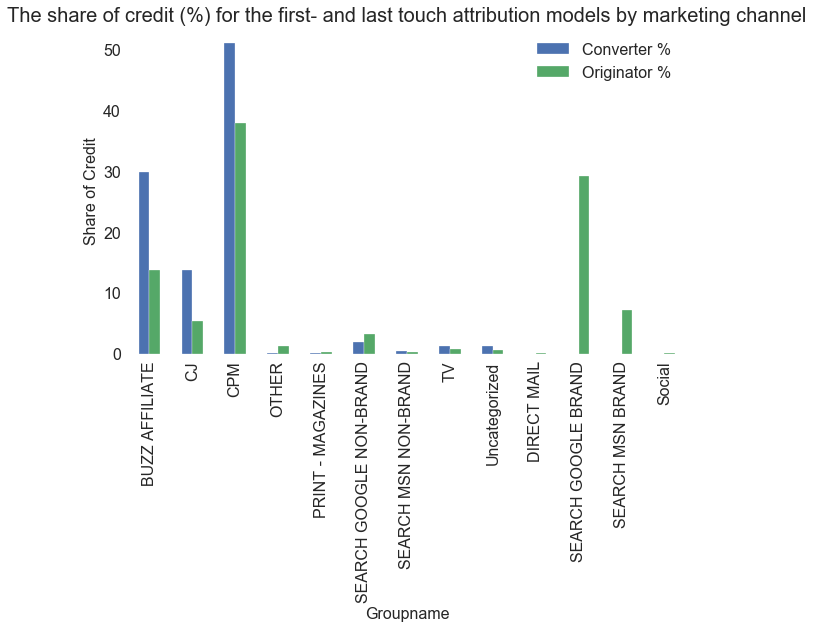

In [38]:
first_last[:13].plot(x='index', y=['Converter %', 'Originator %'], kind='bar', figsize=(10, 6))
plt.xlabel('Groupname')
plt.ylabel('Share of Credit')
plt.title('The share of credit (%) for the first- and last touch attribution models by marketing channel');

**c) (10 pts) Compare results from the two attribution model. What would be the
consequence to Winters if it allocated its marketing budget entirely based on the lasttouch attribution model?**

The CPM channel has the share of credit when using both first and last touch attribution models (51.01% and 37.98% respectively). The Buzz Affiliates channel holds the second highest share of credit when using the last touch attribution model (29.87%), but has a significantly lower proportion of credit share for the first touch attribution model (13.83%). When customers search for google brands, the first touch attribution displays that this accounts to 29.13% of the total share of credit. The CJ channel has the third highest share of credit (13.77%) across the last touch attribution model. We note that all other channels have less than 8% of the total share of credit across both the first and last touch attribution models. This implies that CPM and Buzz Affiliates have the highest share of credits across both models, with an addition of the CJ channel's share of credit only for the last touch attribution model. 

If the marketing budget is allocated entirely based on the last touch attribution model, then Winters will not be able to account for the consumer interactions with all other touchpoints. There might be an interaction effect between all these different marketing touchpoints, which a single touch model (either first or last touch model) will fail to take into account. 

**Q2. (20 pts) Compare new customers and old customers**

**a) (5 pts) What is the average number of days that it takes for a new customer to convert (from the first touchpoint)? What is the average number of days that it takes for an old customer to convert?**

In [39]:
num_order_new = len(df[(df['Positionname']=='CONVERTER')&(df['Newcustomer'] == 'Y')])
num_order_old = len(df[(df['Positionname']=='CONVERTER')&(df['Newcustomer'] == 'N')])

In [40]:
new_firsttouchpoint = df[(df['Newcustomer'] == 'Y') & (df['Positionname'] == 'ORIGINATOR')]
print(np.round(new_firsttouchpoint.DaysToConvert.mean(),2))

5.5


In [41]:
old_firsttouchpoint = df[(df['Newcustomer'] == 'N') & (df['Positionname'] == 'ORIGINATOR')]
print(np.round(old_firsttouchpoint.DaysToConvert.mean(),2))

32.01


On average, it takes 5.5 days for a new customer to convert from the first touch point. And it takes 32.01 days for an old customer to convert from the first touch point.

**b) (5 pts) What is the average number of touchpoints by new versus old customer’s orders? Hint: Use the Touches variable if available. If not, create the ‘Touches’ variable for the number of touchpoints per order. R users can use the add_count() function.**

In [42]:
new = df[df['Newcustomer'] == 'Y']
temp = new.groupby('Orderid')['Position'].count()
temp_new = pd.DataFrame(temp)
temp_new['Touches'] = temp_new['Position']
temp_new = temp_new['Touches']
temp_new = pd.DataFrame(temp_new)
temp_new

,Touches
Orderid,
11634052,2
11634059,3
11634191,4
11634217,3
11634218,5
...,...
11777393,2
11777407,3
11777419,2


In [43]:
old = df[df['Newcustomer'] == 'N']
temp = old.groupby('Orderid')['Position'].count()
temp_old = pd.DataFrame(temp)
temp_old['Touches'] = temp_old['Position']
temp_old = temp_old['Touches']
temp_old = pd.DataFrame(temp_old)
temp_old

,Touches
Orderid,
11634060,8
11634119,2
11635494,4
11636452,6
11637581,4
...,...
11776990,4
11777034,5
11777068,7


In [44]:
print(np.round(temp_new['Touches'].mean(),2))
print(np.round(temp_old['Touches'].mean(),2))

4.32
5.24


New customers on average have 4.32 touchpoints while old customers on average have 5.24 touchpoints.

**c) (5 pts) What is the average order sales amount by new versus old customer’s orders?**

In [45]:
temp2 = new.groupby('Orderid')['Saleamount'].mean()
temp2_new = pd.DataFrame(temp2)
temp2_new

,Saleamount
Orderid,
11634052,341.50
11634059,339.00
11634191,315.00
11634217,731.60
11634218,256.50
...,...
11777393,253.21
11777407,341.50
11777419,99.00


In [46]:
temp2 = old.groupby('Orderid')['Saleamount'].mean()
temp2_old = pd.DataFrame(temp2)
temp2_old

,Saleamount
Orderid,
11634060,101.79
11634119,174.69
11635494,107.76
11636452,291.48
11637581,184.15
...,...
11776990,177.54
11777034,90.71
11777068,282.69


In [47]:
print(np.round(temp2_new['Saleamount'].mean(),2))
print(np.round(temp2_old['Saleamount'].mean(),2))

267.57
208.22


The average order sales for new customers' orders is 267.57 USD while the average order sales for old customers' orders is 208.22 USD.

**d) (5 pts) Summarize how new and old customers differ along these three variables.**

The three variables used for the summary include the average number of days to convert, average number of touchpoints and average order sales for customers' orders. 

Old customers take approximately 27 days more to convert than new customers and they have a marginally higher number of touchpoints on average (old customers have 5.34 touchpoints on average while new customers have 4.32 touchpoints on average). However, the average order sales for new customers' is higher than that of old customers. This indicates that there might be some new customers who might be making bulk purchases, while old customers prefer to visit the site regularly to make smaller purchases. Old customers might prefer browsing on the website longer before making a purchase, which in turn leads to having more touchpoints when browsing longer on the site. 

**Q3. (20 pts) Consider the revenue per marketing channel using first-touch attribution.**

**a) (10 pts) Create a table (as in Q1) containing the average sales per order as well as the total revenue by originator channel.**

In [48]:
df1=pd.DataFrame(df.loc[df['Positionname']=='ORIGINATOR'])
originator1 = pd.DataFrame(df1.groupby('Groupname')['Saleamount'].mean())
originator2 = pd.DataFrame(df1.groupby('Groupname')['Saleamount'].sum())

# merging the 2 tables 
merge_1 = np.round(pd.merge(originator1, originator2, how = 'outer', on = 'Groupname').fillna(0).rename(
    columns={"Saleamount_x": "avg_sale", "Saleamount_y": "total_revenue"}), 2)
merge_1

,avg_sale,total_revenue
Groupname,,
BUZZ AFFILIATE,253.29,56990.67
CJ,249.26,21685.82
CPM,240.46,148603.61
DIRECT MAIL,170.98,170.98
OTHER,226.38,4527.62
PRINT - MAGAZINES,262.98,1051.91
SEARCH GOOGLE BRAND,243.89,115601.81
SEARCH GOOGLE NON-BRAND,245.82,13028.48
SEARCH MSN BRAND,246.33,28820.56


**b) (5 pts) What is the total incremental gross revenue accruing to Winters by originator channel? Express your answer in a table. Assume that Winters has a gross margin of 40%. Also assume 5% of sales from branded search are incremental, and 10% sales are incremental for the remaining channels.**

In [49]:
merge_2 = merge_1.copy()
merge_2['rate'] = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1]
merge_2['incre_revenue'] = np.round(merge_2['total_revenue'] * merge_2['rate'] * 0.4,2)
merge_2

,avg_sale,total_revenue,rate,incre_revenue
Groupname,,,,
BUZZ AFFILIATE,253.29,56990.67,0.10,2279.63
CJ,249.26,21685.82,0.10,867.43
CPM,240.46,148603.61,0.10,5944.14
DIRECT MAIL,170.98,170.98,0.10,6.84
OTHER,226.38,4527.62,0.10,181.10
PRINT - MAGAZINES,262.98,1051.91,0.10,42.08
SEARCH GOOGLE BRAND,243.89,115601.81,0.05,2312.04
SEARCH GOOGLE NON-BRAND,245.82,13028.48,0.10,521.14
SEARCH MSN BRAND,246.33,28820.56,0.05,576.41


**c) (5 pts) You just found out that Winters search ad team spent $4,200 on branded search advertising during the time period in the data. What is your advice to the search team based on the calculation above?**

In [50]:
#calculating the sum of incremental revenue for the Search Google Brand and Search MSN Brand channels
print(merge_2.iloc[6,3] + merge_2.iloc[8,3])

2888.45


In [51]:
# calculating the difference between the amount spent by the ad team and the incremental revenue for the Search Google Brand and Search MSN Brand channels
print(np.round(4200-(merge_2.iloc[6,3] + merge_2.iloc[8,3]),2))

1311.55


The above calculations display that:

- The total amount of incremental revenue for branded search advertising is $2888.45

- The increment revenue for branded search advertising is lesser than the amount spent on branded search advertising by $1311.55, which indicates that the current strategy used (within the time period in the data) is not profitable. 

Based on these two points above, we would advice the search ad team to improve their current search ad strategy by:

- Choose and match your keywords with prospective customers and leverage keyword research tools such as Google keyword planner and Moz keyword explorer
- Include ad extensions by specifying all extension available which will improve quality score at no additional costs
- Optimize ad content and landing page

Alternatively, the team can also redirect their advertising spend on other channels that have higher incremental revenue growth.

**Q4. (25 pts) Linear/uniform attribution
The linear attribution model divides the attribution share between touches equally. For example, an order with one CPM, one CJ, and one TV touchpoint will have place one third attribution share on each touch. This can be accomplished by using the Touches variable (see Q2) to define a new variable:
LinearAttributionShare = 1 / Touches**

**a) (10 pts) For each channel, what is the sum of the linear attribution shares? What is the corresponding share of credit (in percentage) according to the linear attribution model? Express your answer in a table like in Q1.**

In [52]:
temp = df.groupby('Orderid')['Position'].count()
uniform_df = pd.DataFrame(temp)
uniform_df['Touches'] = uniform_df['Position']
uniform_df = uniform_df['Touches']
uniform = pd.DataFrame(uniform_df)

df_uniform = pd.merge(df, uniform, how = 'outer', on = 'Orderid').fillna(0)
df_uniform['LinearAttributionShare'] = 1/(df_uniform.Touches)
linear = pd.DataFrame(df_uniform.groupby('Groupname')['LinearAttributionShare'].sum())
linear['Linear_ShareOfCredit %'] = linear['LinearAttributionShare']/sum(linear['LinearAttributionShare'])*100
linear = np.round(linear, decimals=2)
linear

,LinearAttributionShare,Linear_ShareOfCredit %
Groupname,,
BUZZ AFFILIATE,338.99,20.84
CJ,132.88,8.17
CPM,827.93,50.89
DIRECT MAIL,0.33,0.02
OTHER,8.11,0.50
PRINT - MAGAZINES,3.18,0.20
SEARCH GOOGLE BRAND,200.95,12.35
SEARCH GOOGLE NON-BRAND,31.50,1.94
SEARCH MSN BRAND,46.88,2.88


**b) (10 pts) In a single bar chart, plot the share of credit (in percentage) for all three attribution models: first-touch, last-touch and linear.**

In [53]:
first_last['Channels'] = first_last['index']
linear['Channels'] = linear.index
merge_3= np.round(pd.merge(first_last, linear, how = 'outer', on = 'Channels').fillna(0), 2)
merge_3['FirstT_share%'] = merge_3['Originator %']
merge_3['LastT_share%'] = merge_3['Converter %']
merge_3['Linear_share%'] = merge_3['Linear_ShareOfCredit %']
merge_3 = merge_3[['index', 'FirstT_share%', 'LastT_share%', 'Linear_share%']]
merge_3 = merge_3[:13]
merge_3

,index,FirstT_share%,LastT_share%,Linear_share%
0,BUZZ AFFILIATE,13.83,29.87,20.84
1,CJ,5.35,13.77,8.17
2,CPM,37.98,51.01,50.89
3,OTHER,1.23,0.18,0.50
4,PRINT - MAGAZINES,0.25,0.18,0.20
5,SEARCH GOOGLE NON-BRAND,3.26,1.97,1.94
6,SEARCH MSN NON-BRAND,0.25,0.43,0.30
7,TV,0.86,1.23,0.86
8,Uncategorized,0.55,1.35,1.04
9,DIRECT MAIL,0.06,0.00,0.02


Text(0.5, 1.0, 'The share of credit (%) for all three attribution models')

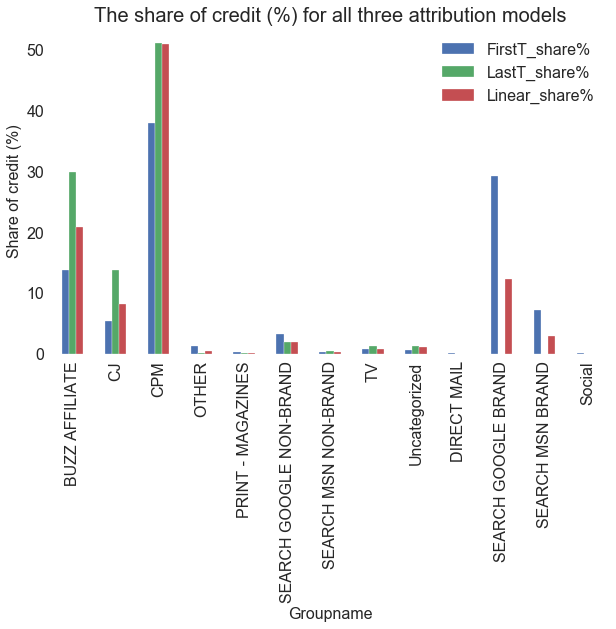

In [54]:
merge_3[:13].plot(x='index', y=['FirstT_share%', 'LastT_share%', 'Linear_share%'], kind='bar', figsize=(10, 6))
plt.xlabel('Groupname')
plt.ylabel('Share of credit (%)')
plt.title('The share of credit (%) for all three attribution models')

**c) (5 pts) Compare the linear model to the first-touch and last-touch models.**

CPM holds the highest share of credit across all 3 models (~50% for last touch and linear models and 37.98% for the first touch model). The Buzz Affiliate channel nholds the second highest share of credit across both the linear and last touch models. Noticeably, both search channels (Google and MSN) only display share of credit across linear and first touch models. The linear model is the only attribution model that has share of credit across all 13 channels. 

The linear model has some disadvantages as well. While it assigns equal credits to each touchpoint, we lose the ability to examine the true impact of each touchpoint on the sale.

**Q5. (30 pts) Examine the role of the intermediate (Roster and Assist) touch points.**

**a) (10 pts) Focusing on the top channels, what is the proportion of each channel’s touchpoints by position name: 1) Originator, 2) Roster, 3) Assist, and 4) Converter. Show your result using a table like the following (with the exact top channels listed)**

In [55]:
filter_df = df[(df['Groupname'] == 'BUZZ AFFILIATE') | (df['Groupname'] == 'CJ') |  (df['Groupname'] == 'CPM') |  (df['Groupname'] == 'SEARCH GOOGLE BRAND') |  (df['Groupname'] == 'SEARCH GOOGLE NON-BRAND') |  (df['Groupname'] == 'SEARCH MSN BRAND') |  (df['Groupname'] == 'TV')]
channel = pd.DataFrame(filter_df.groupby(['Groupname', 'Positionname'])['Position'].count())
channel.reset_index(inplace=True)
channel_pivot = channel.pivot(index='Groupname', columns='Positionname', values='Position')
channel_pivot = channel_pivot.fillna(0)
channel_pivot['Total_old'] = channel_pivot.ASSIST + channel_pivot.CONVERTER + channel_pivot.ORIGINATOR + channel_pivot.ROSTER
channel_pivot['ASSIST'] = channel_pivot['ASSIST']/channel_pivot['Total_old']*100
channel_pivot['CONVERTER'] = channel_pivot['CONVERTER']/channel_pivot['Total_old']*100
channel_pivot['ORIGINATOR'] = channel_pivot['ORIGINATOR']/channel_pivot['Total_old']*100
channel_pivot['ROSTER'] = channel_pivot['ROSTER']/channel_pivot['Total_old']*100
channel_pivot['TOTAL'] = channel_pivot.ASSIST + channel_pivot.CONVERTER + channel_pivot.ORIGINATOR + channel_pivot.ROSTER
channel_pivot.drop(columns=['Total_old'], inplace=True)
channel_pivot = np.round(channel_pivot,2)
channel_pivot

Positionname,ASSIST,CONVERTER,ORIGINATOR,ROSTER,TOTAL
Groupname,,,,,
BUZZ AFFILIATE,18.83,34.54,15.99,30.63,100.0
CJ,16.48,42.91,16.67,23.95,100.0
CPM,18.08,18.76,13.97,49.19,100.0
SEARCH GOOGLE BRAND,12.77,0.00,59.32,27.91,100.0
SEARCH GOOGLE NON-BRAND,6.48,29.63,49.07,14.81,100.0
SEARCH MSN BRAND,7.60,0.00,68.42,23.98,100.0
TV,12.28,35.09,24.56,28.07,100.0


**b) (10 pts) In a single bar chart, plot the share in percentage (y-axis) of touchpoint types by marketing channels (x-axis).**

Text(0.5, 1.0, 'The share in percentage of touchpoint types by marketing channels')

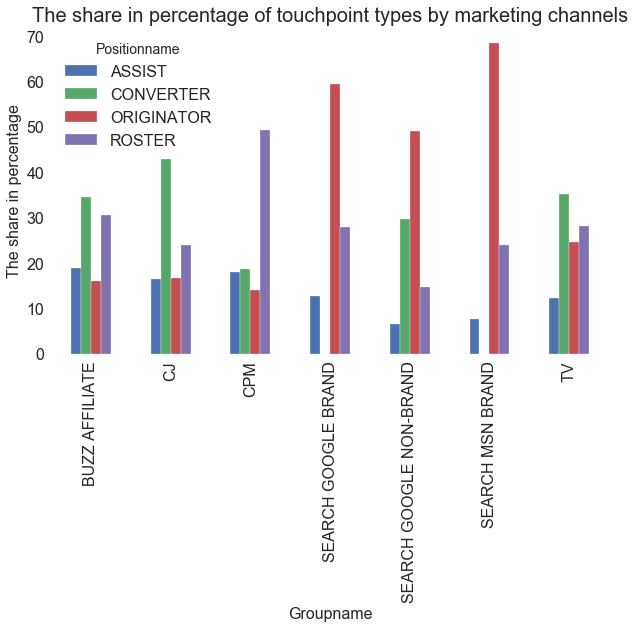

In [56]:
channel_pivot[['ASSIST', 'CONVERTER', 'ORIGINATOR', 'ROSTER']].plot(kind='bar', figsize=(10, 6))
plt.ylabel('The share in percentage')
plt.title('The share in percentage of touchpoint types by marketing channels')

**c) (10 pts) Summarize the touch-point type results. Which channels seem to have relatively more or less of its touchpoints as rosters and assist?** 


All channels include 'rosters' and assist as 'touchpoints', as opposed to the 'converter', where both searches (MSN and Google) don't have any proportion of the 'converter' touchpoint. 

**Roster**

*  The CPM, Buzz Affiliate, Search Google Brand and TV channels have a higher proportion of 'Rosters' as their touchpoints (49.18%, 30.63%, 27.91% and 28.07% respectively). 
*  The CJ, Search Google Non-Brand and Search MSN Brand channels have  lower proportion of 'Rosters' as their touchpoints (23.95%, 14.81% and 23.98% respectively). 

**Assist**

*  The CPM, Buzz Affiliate and CJ channels have a higher proportion of 'Rosters' as their touchpoints (18.08%, 18.83% and 16.48% respectively). 
*  The Search Google Non-Brand, Search MSN Brand and TV channels have a lower proportion of 'Rosters' as their touchpoints (6.48%, 7.60% and 12.28% respectively). 


**Compared with linear attribution, which of these channels would receive too much or too little credit under first- and lasttouch attribution?**

*  The graph in 4b) displays that the channels with the highest share of credit based on the linear attribution model include CPM, Buzz Affiliates and Search Google Brand (50.88%, 20.84% and 12.35% respectively). 
*  In the above graph, we notice that the channels with the highest proportion of 'Originator' (first touch attribution) include Search Google Brand, Search Google Non Brand and Search MSN Brand, out of which the only overlap between this and the share of credit in the linear attribution model is with the Search Google Brand channel. The Search Google Brand channel has the second highest proportion of 'Originators' as its touchpoint, and the linear attribution model displays a slightly high share of credit for this channel (12.35%).
*  In the above graph, we notice that the channels with the highest proportion of 'Convertor' (last touch attribution) include CJ, Buzz Affiliate, Search Google Non-Brand and TV, out of which the only overlap between this and the share of credit in the linear attribution model is with the Buzz Affiliates. The Buzz Affiliates channel has the third highest proportion of 'Convertors' as its touchpoint, and the linear attribution model displays a high share of credit for this channel (20.84%).
*  The CPM channel has relatively low proportions of 'Originator' and 'Convertor' as touchpoints, as compared to the linear attribution model which displays the highest share of credit for this channel (50.88%).



---
